# Experimentation in Action: Testing & Evaluating a Project

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Mathematics
from math import sqrt

# Data Visualization
import matplotlib.pylab as plt
import seaborn as sns

# Scikit-Learn

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score 

# Dates
from dateutil.parser import parse

# Statistical Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#

#### Loading Data

In [3]:
DATA_PATH = '/Users/isisromero/desktop/MLEIA/chap_06/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'
AIRPORT_FIELD = 'Airport Code'

def apply_index_freq(data, freq):
    return data.asfreq(freq)

def pull_raw_airport_data(file_location):
    raw = pd.read_csv(file_location)
    raw = raw.copy(deep=False)
    raw['Month'] = pd.to_datetime(raw['Month'], format='%b').dt.month
    raw.loc[:, 'Day'] = 1
    raw['date'] = pd.to_datetime(raw[['Year', 'Month', 'Day']])
    raw.set_index('date', inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    asc = raw.sort_index()
    return asc

def get_airport_data(airport, file_location): 
    all_data = pull_raw_airport_data(file_location)
    filtered = all_data[all_data[AIRPORT_FIELD] == airport]
    return filtered

In [4]:
def exp_smoothing(raw_series, alpha=0.05): 
    output = [raw_series[0]]
    
    for i in range(1, len(raw_series)):
        output.append(raw_series[i] * alpha + (1-alpha) * output[i-1])
    return output

#### Mean Absolute Error & Uncertainty

In [5]:
def calculate_mae(raw_series, smoothed_series, window, scale):
    res = {}
    mae_value = mean_absolute_error(raw_series[window:], smoothed_series[window:])
    res['mae'] = mae_value
    deviation = np.std(raw_series[window:] - smoothed_series[window:])
    res['stddev'] = deviation
    yhat = mae_value + scale * deviation
    res['yhat_low'] = smoothed_series - yhat
    res['yhat_high'] = smoothed_series + yhat
    return res

#### Setting Function for Generating Exponential Smoothing & Moving Average Data & Visualizations

In [8]:
def smoothed_time_plots(time_series, time_series_name, image_name, smoothing_window, exp_alpha=0.05, 
                        yhat_scale=1.96, style='seaborn-v0_8-darkgrid', plot_size=(16, 24)):
    reference_collection = {}
    ts = pd.Series(time_series)
    with plt.style.context(style=style):
        fig, axes = plt.subplots(3, 1, figsize=plot_size)  
        plt.subplots_adjust(hspace=0.3)
        
        # Series for Rolling Moving Average over a Specified Window 
        moving_avg = ts.rolling(window=smoothing_window).mean()
        
        # Exponentially Smoothed Average Series 
        exp_smoothed = exp_smoothing(ts, exp_alpha)
        
        # MAE and the Error Estimations for Moving Average
        res = calculate_mae(time_series, moving_avg, smoothing_window, yhat_scale)
        
        # MAE and Error Estimations on Exponentially Smoothed Data
        res_exp = calculate_mae(time_series, exp_smoothed, smoothing_window, yhat_scale)
        
        # Pandas Series from the Exponentially Smoothed Data
        exp_data = pd.Series(exp_smoothed, index=time_series.index)
        
        # Pandas Series for the StdDev Error Trends
        exp_yhat_low_data = pd.Series(res_exp['yhat_low'], index=time_series.index)
        exp_yhat_high_data = pd.Series(res_exp['yhat_high'], index=time_series.index)
        
        # Raw Data
        axes[0].plot(ts, '-', label='Trend for {}'.format(time_series_name))
        axes[0].legend(loc='upper left')
        axes[0].set_title('Raw Data trend for {}'.format(time_series_name))
        axes[0].grid(True)
        
        # Moving Average Data
        axes[1].plot(ts, '-', label='Trend for {}'.format(time_series_name))
        axes[1].plot(moving_avg, 'g-', label='Moving Average with window: {}'.format(smoothing_window))
        axes[1].plot(res['yhat_high'], 'r--', label='yhat bounds')
        axes[1].plot(res['yhat_low'], 'r--')
        axes[1].set_title('Moving Average Trend for window: {} with MAE of: {:.1f}'.format(smoothing_window, res['mae'])) #G
        axes[1].legend(loc='upper left')
        axes[1].grid(True)
        
        # Exponentially Smoothed Data
        axes[2].plot(ts, '-', label='Trend for {}'.format(time_series_name))
        axes[2].legend(loc='upper left')
        axes[2].plot(exp_data, 'g-', label='Exponential Smoothing with alpha: {}'.format(exp_alpha))
        axes[2].plot(exp_yhat_high_data, 'r--', label='yhat bounds')
        axes[2].plot(exp_yhat_low_data, 'r--')
        axes[2].set_title('Exponential Smoothing Trend for alpha: {} with MAE of: {:.1f}'.format(exp_alpha, res_exp['mae']))
        axes[2].legend(loc='upper left')
        axes[2].grid(True)
        
        plt.savefig(image_name, format='svg')
        
        plt.tight_layout()
        
        reference_collection['plots'] = fig
        reference_collection['moving_average'] = moving_avg
        reference_collection['exp_smooth'] = exp_smoothed
        
        return reference_collection

#### Smoothing Function for Series Data & Visualizations

/var/folders/dk/f9pbhbp52qxc0613mpbtx8lm0000gn/T/ipykernel_32872/3010081859.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output = [raw_series[0]]
/var/folders/dk/f9pbhbp52qxc0613mpbtx8lm0000gn/T/ipykernel_32872/3010081859.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output.append(raw_series[i] * alpha + (1-alpha) * output[i-1])


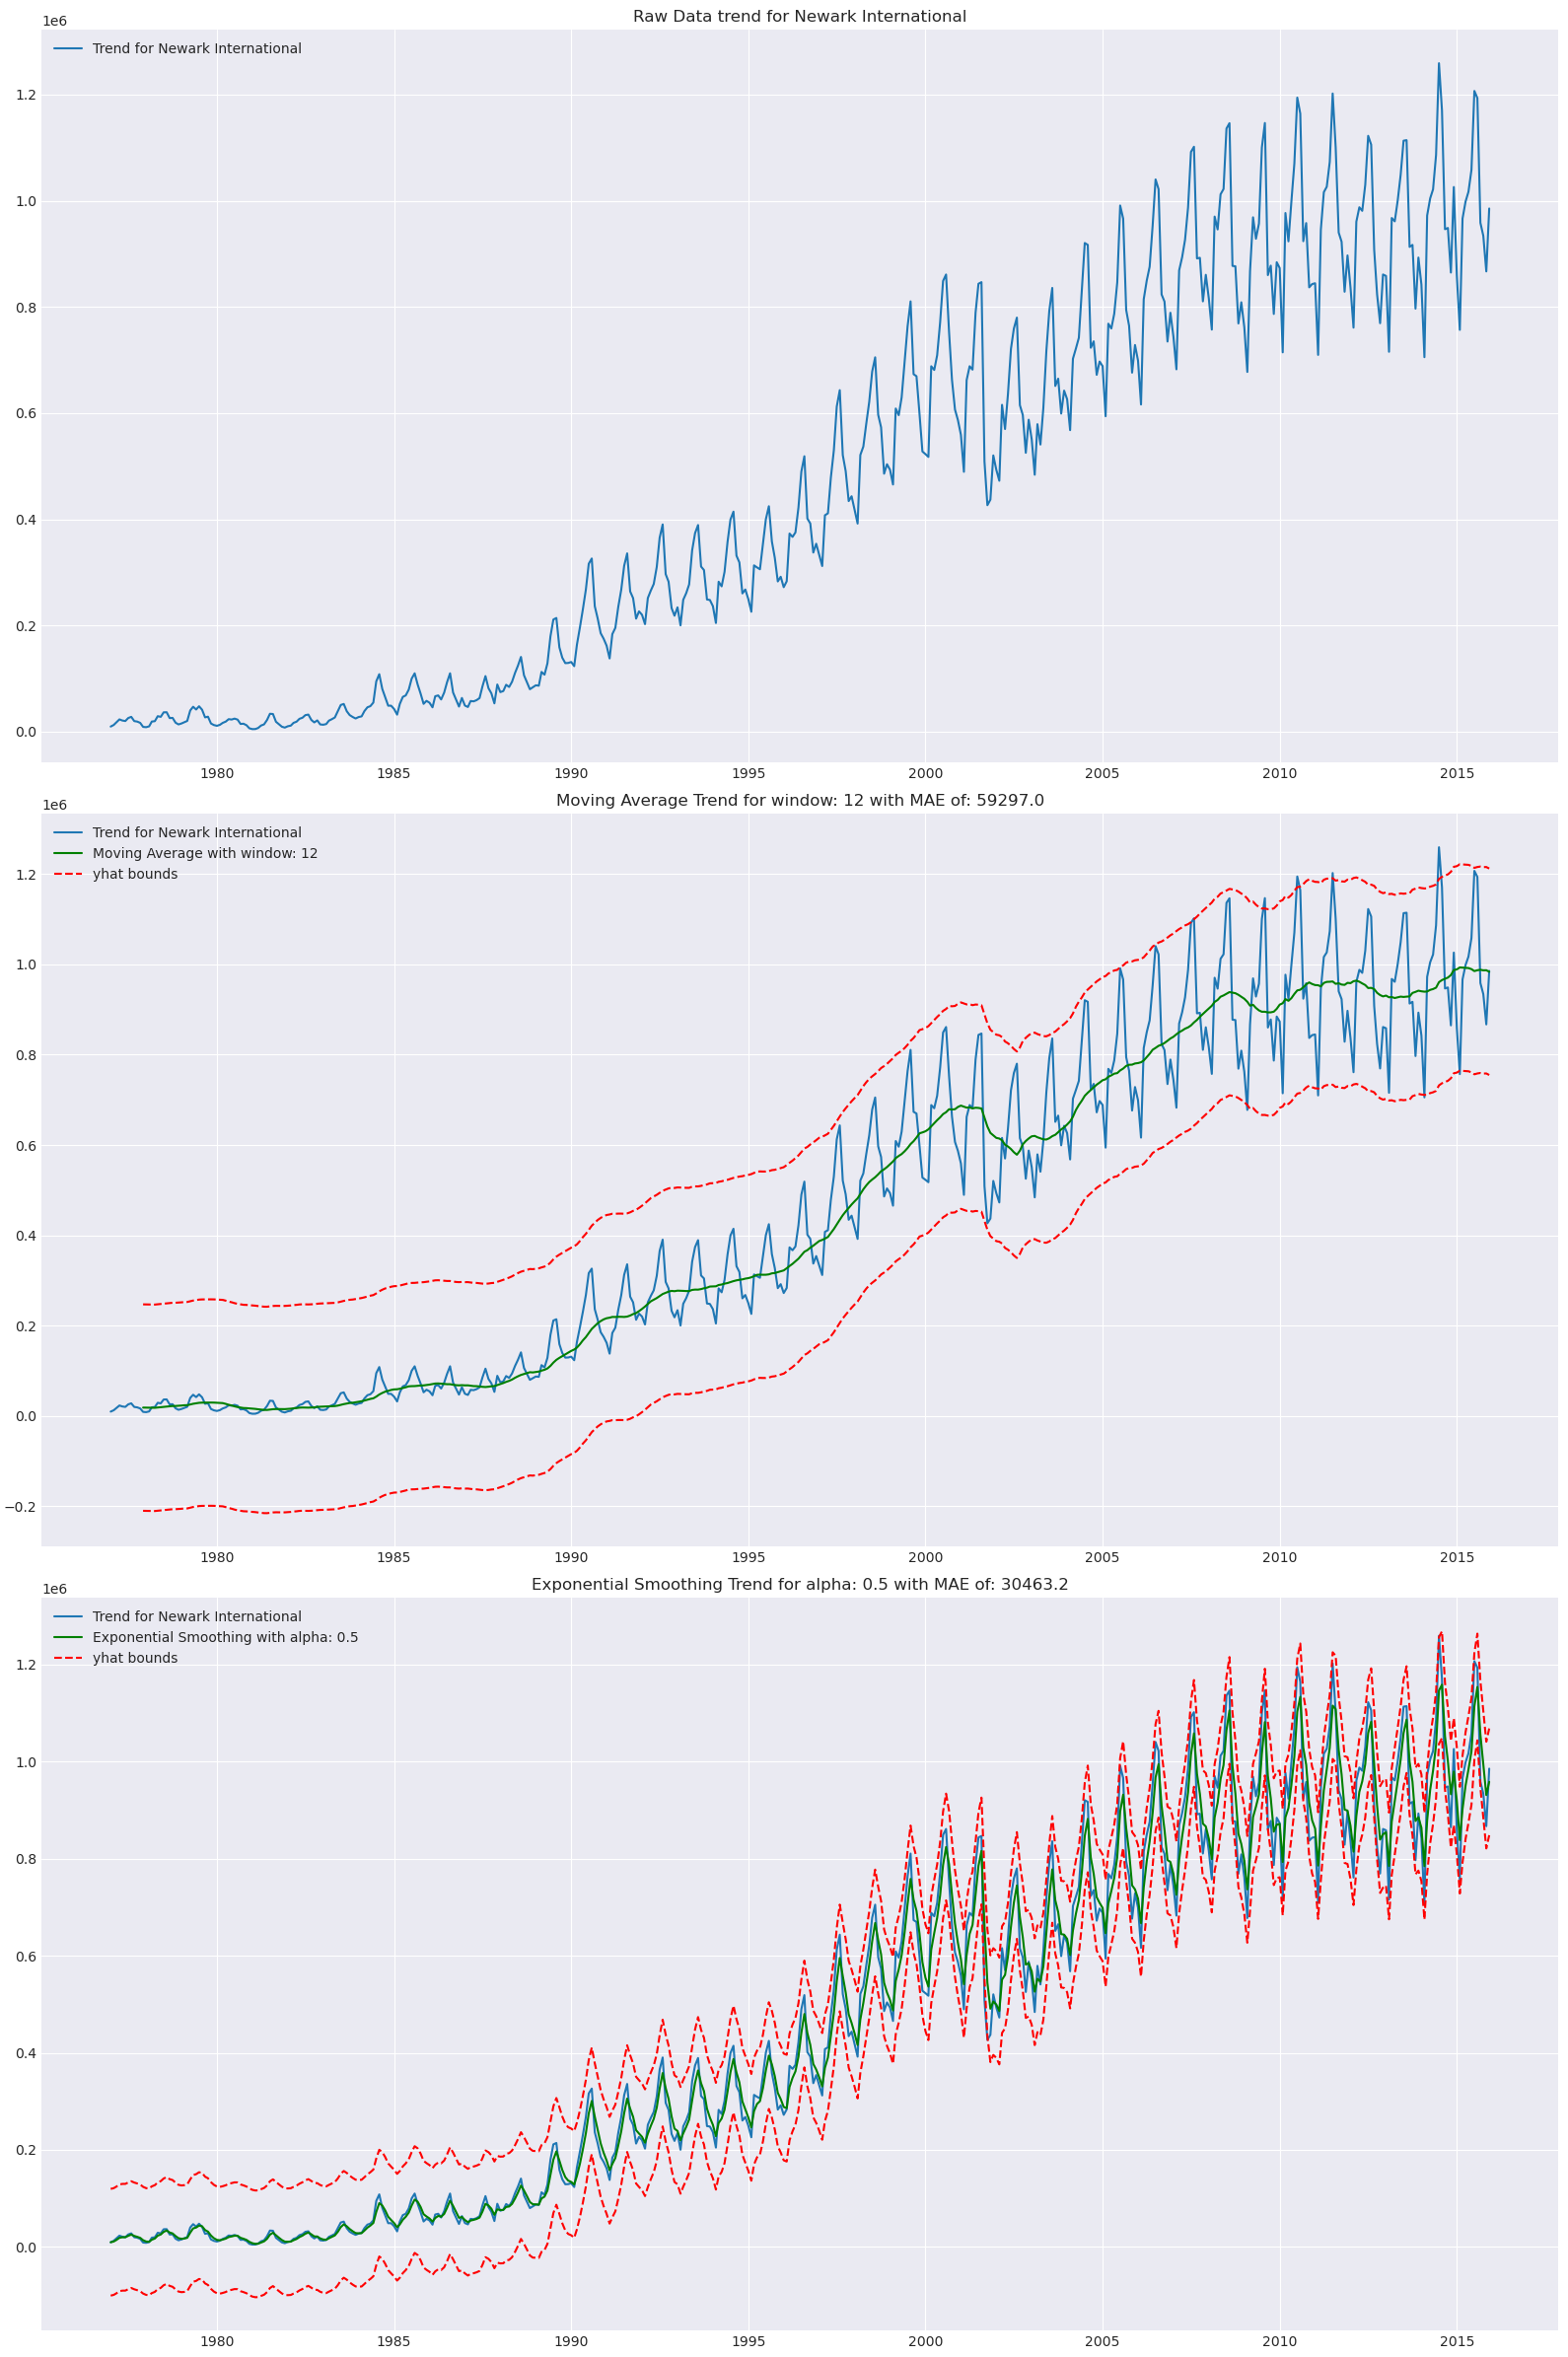

In [9]:
ewr_data = get_airport_data('EWR', DATA_PATH)

ewr_reference = smoothed_time_plots(ewr_data['International Passengers'], 'Newark International', 
                                    'newark_dom_smooth_plot.svg', 12, exp_alpha=0.5)